# 🎯 BERT Turkish Address Classification with Focal Loss

## Notebook Sırası:
1. **Preprocessing Function** - BERT-optimized Turkish address preprocessing
2. **Data Loading** - Dataset yükleme ve preprocessing uygulama
3. **Focal Loss Implementation** - Standard ve Class-wise Focal Loss
4. **Training Setup** - Model, trainer ve parametreler
5. **Training Execution** - Eğitimin başlatılması
6. **Analysis** - Sınıf dağılımı ve parametre analizi
7. **Results** - Model kaydetme ve sonuçlar

In [9]:
# ===== BERT-OPTIMIZED TURKISH ADDRESS PREPROCESSING =====
import re
from unidecode import unidecode

def bert_optimized_address_preprocessing(text):
    """
    BERT modeli için optimize edilmiş Türkçe adres preprocessing fonksiyonu.
    Tüm preprocessing adımlarını birleştirir ve BERT'in en iyi performansı için tasarlanmıştır.
    """
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Orijinal metni koru (bazı analizler için)
    original_text = text
    
    # --- PHASE 1: INITIAL CLEANING ---
    # Küçük harfe çevir
    text = text.lower().strip()
    
    # Çoklu boşlukları ve tab/newline karakterlerini temizle
    text = re.sub(r'\s+', ' ', text)
    
    # --- PHASE 2: TURKISH CHARACTER NORMALIZATION ---
    # Türkçe karakterleri kontrollü şekilde normalize et (BERT türkçe modeli için optimize)
    turkish_normalization = {
        'ç': 'c', 'ğ': 'g', 'ı': 'i', 'ö': 'o', 'ş': 's', 'ü': 'u',
        'â': 'a', 'î': 'i', 'û': 'u', 'ô': 'o'
    }
    for tr_char, en_char in turkish_normalization.items():
        text = text.replace(tr_char, en_char)
    
    # --- PHASE 3: NUMBER & ALPHANUMERIC STANDARDIZATION ---
    # Sayı ve alfanümerik kodları standardize et (BERT tokenization için)
    
    # Alfanümerik kodları ayır: 24/A → 24 A, 12/B → 12 B
    text = re.sub(r'\b(\d+)\s*[/\-\\]\s*([a-zA-Z]\d*)\b', r'\1 \2', text)
    
    # Sayı kombinasyonlarını ayır: 24/5 → 24 5, 3/12 → 3 12  
    text = re.sub(r'\b(\d+)\s*[/\-\\]\s*(\d+)\b', r'\1 \2', text)
    
    # Noktalı sayıları ayır: 24.5 → 24 5 (BERT için)
    text = re.sub(r'\b(\d+)[.,](\d+)\b', r'\1 \2', text)
    
    # --- PHASE 4: COMPREHENSIVE ABBREVIATION EXPANSION ---
    # Türkiye'de yaygın kullanılan adres kısaltmaları
    abbreviations = {
        # Temel adres bileşenleri
        r'\bmah\.?\b': 'mahallesi',
        r'\bmahalle\b': 'mahallesi',
        r'\bmhl\.?\b': 'mahallesi',
        
        r'\bsok\.?\b': 'sokak',
        r'\bsk\.?\b': 'sokak',
        r'\bsokagi\b': 'sokak',
        
        r'\bcad\.?\b': 'caddesi',
        r'\bcd\.?\b': 'caddesi',
        r'\bcaddesi\b': 'caddesi',
        
        r'\bblv\.?\b': 'bulvari',
        r'\bbulvar\b': 'bulvari',
        r'\bblvr\.?\b': 'bulvari',
        
        r'\bno\.?\b': 'numara',
        r'\bnumara\b': 'numara',
        r'\bnum\.?\b': 'numara',
        
        # Yapı bileşenleri
        r'\bapt\.?\b': 'apartmani',
        r'\bapartman\b': 'apartmani',
        r'\bapart\.?\b': 'apartmani',
        
        r'\bd\.?\b': 'daire',
        r'\bdaire\b': 'daire',
        r'\bdr\.?\b': 'daire',
        
        r'\bk\.?\b': 'kat',
        r'\bkat\b': 'kat',
        r'\bkati\b': 'kat',
        
        r'\bblok\b': 'blok',
        r'\bbl\.?\b': 'blok',
        
        # Site ve kompleks
        r'\bsit\.?\b': 'sitesi',
        r'\bsite\b': 'sitesi',
        r'\bkonut\.?\b': 'konutlari',
        r'\bkompleks\b': 'kompleksi',
        r'\brezidans\b': 'rezidansi',
        
        # Diğer yaygın kısaltmalar
        r'\bpk\.?\b': 'park',
        r'\bpark\b': 'park',
        r'\bmez\.?\b': 'mezarligi',
        r'\bmeydan\b': 'meydani',
        r'\bmeyd\.?\b': 'meydani',
        r'\bçık\.?\b': 'cikmazı',
        r'\bçıkmaz\b': 'cikmazı'
    }
    
    for abbr_pattern, full_form in abbreviations.items():
        text = re.sub(abbr_pattern, full_form, text, flags=re.IGNORECASE)
    
    # --- PHASE 5: GEOGRAPHIC STANDARDIZATION ---
    # Yön ve konum belirteçleri
    directional_terms = {
        r'\bkuzey\b': 'kuzey',
        r'\bguney\b': 'guney',
        r'\bdogu\b': 'dogu',
        r'\bbati\b': 'bati',
        r'\biç\b': 'ic',
        r'\biçi\b': 'ic',
        r'\bdış\b': 'dis',
        r'\bdışı\b': 'dis',
        r'\balt\b': 'alt',
        r'\büst\b': 'ust',
        r'\bön\b': 'on',
        r'\barka\b': 'arka',
        r'\bsag\b': 'sag',
        r'\bsol\b': 'sol'
    }
    
    for direction_pattern, standardized in directional_terms.items():
        text = re.sub(direction_pattern, standardized, text, flags=re.IGNORECASE)
    
    # --- PHASE 6: CITY/DISTRICT NORMALIZATION ---
    # Büyük şehir ve ilçe isimleri standardizasyonu
    major_locations = {
        r'\bist\.?\b': 'istanbul',
        r'\bistanbul\b': 'istanbul',
        r'\bank\.?\b': 'ankara',
        r'\bankara\b': 'ankara',
        r'\bizm\.?\b': 'izmir',
        r'\bizmir\b': 'izmir',
        r'\bbeyoglu\b': 'beyoglu',
        r'\bkadikoy\b': 'kadikoy',
        r'\bbesiktas\b': 'besiktas',
        r'\buskudar\b': 'uskudar',
        r'\bsisli\b': 'sisli',
        r'\bfatih\b': 'fatih',
        r'\besenler\b': 'esenler',
        r'\bbahcelievler\b': 'bahcelievler'
    }
    
    for location_pattern, standardized in major_locations.items():
        text = re.sub(location_pattern, standardized, text, flags=re.IGNORECASE)
    
    # --- PHASE 7: NOISE REMOVAL ---
    # Gereksiz kelime ve ifadeleri kaldır
    noise_patterns = [
        r'\bmevki\b', r'\bmevkii\b', r'\byakini\b', r'\bcivarı\b',
        r'\bkarsisi\b', r'\bkarsisinda\b', r'\byani\b', r'\byaninda\b',
        r'\bonu\b', r'\bonunde\b', r'\barkasi\b', r'\barkasinda\b',
        r'\biçinde\b', r'\biçerisinde\b', r'\buzerinde\b', r'\baltinda\b'
    ]
    
    for noise_pattern in noise_patterns:
        text = re.sub(noise_pattern, '', text, flags=re.IGNORECASE)
    
    # --- PHASE 8: FEATURE EXTRACTION & TAGGING ---
    features = []
    
    # Posta kodu tespiti ve DOĞRUDAN EKLEME (generic tag yerine)
    postal_matches = re.findall(r'\b\d{5}\b', original_text)
    if postal_matches:
        # En büyük posta kodunu al (çoklu varsa en önemlisi genelde büyük olandır)
        main_postal = max(postal_matches)
        features.append(f'POSTAL_{main_postal}')
    
    # Apartman tespiti
    if re.search(r'\b(apt|apartman|apart)\b', original_text, re.IGNORECASE):
        features.append('APARTMENT')
    
    # Kat bilgisi tespiti
    if re.search(r'\b(\d+\.?\s*(kat|kati)|kat\s*\d+|(zemin|bodrum|cati)\s*kat)\b', original_text, re.IGNORECASE):
        features.append('FLOOR_INFO')
    
    # Daire/kapı numarası tespiti
    if re.search(r'\b(daire|d\.)\s*\d+\b', original_text, re.IGNORECASE):
        features.append('UNIT_NUMBER')
    
    # Site/kompleks tespiti
    if re.search(r'\b(site|sitesi|kompleks|kompleksi|rezidans|rezidansi|konut)\b', original_text, re.IGNORECASE):
        features.append('COMPLEX')
    
    # Blok bilgisi tespiti
    if re.search(r'\b(blok|bl\.?)\s*[a-zA-Z0-9]\b', original_text, re.IGNORECASE):
        features.append('BLOCK_INFO')
    
    # --- PHASE 9: FINAL CLEANUP ---
    # Özel karakterleri ve noktalamayı temizle (BERT için)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Fazla boşlukları temizle
    text = re.sub(r'\s+', ' ', text).strip()
    
    # AKILLI KELİME FİLTRELEME: Anlamlı tek harfleri koru!
    words = text.split()
    filtered_words = []
    for i, word in enumerate(words):
        # Sayıları her zaman koru
        if word.isdigit():
            filtered_words.append(word)
        # Tek harf ama anlamlı ise koru (A blok, B kapısı vb.)
        elif len(word) == 1 and word.isalpha():
            # Önceki veya sonraki kelimeye bak
            context_words = []
            if i > 0:
                context_words.append(words[i-1].lower())
            if i < len(words) - 1:
                context_words.append(words[i+1].lower())
            
            # Blok, kapi, daire vb. bağlamında tek harf anlamlıdır
            meaningful_contexts = ['blok', 'kapi', 'kapisi', 'daire', 'apartmani', 'sitesi', 'mahallesi']
            if any(ctx in meaningful_contexts for ctx in context_words):
                filtered_words.append(word)
            # Yoksa çok kısa kelimeyi atla
        # Normal kelimeler (2+ karakter)
        elif len(word) >= 2:
            filtered_words.append(word)
    
    text = ' '.join(filtered_words)
    
    # --- PHASE 10: FEATURE INTEGRATION ---
    # Feature'ları metne entegre et (BERT için ek sinyal)
    if features:
        feature_string = ' '.join(features)
        text = f"{text} {feature_string}"
    
    # Final temizlik
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


# 📊 Data Loading & Preprocessing

In [10]:
# --- 1. Gerekli Kütüphanelerin Yüklenmesi ---
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import gc

print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

# --- 2. CLASS IMBALANCE TEST VERİ HAZIRLIĞI ---
print("🔬 CLASS IMBALANCE TEST İÇİN VERİ HAZIRLANIYIOR...")
print("="*60)

df_full = pd.read_csv('train.csv')
df_full = df_full.dropna(subset=['address', 'label'])
df_full['label'] = df_full['label'].astype(int)

# Tüm labelların sample sayılarını hesapla
label_counts = df_full['label'].value_counts()
print(f"📊 Toplam label sayısı: {len(label_counts)}")
print(f"📊 Toplam sample sayısı: {len(df_full)}")

# EN FAZLA VERİYE SAHİP 500 LABEL (High Frequency Classes)
top_500_labels = label_counts.head(500).index.tolist()
top_500_data = df_full[df_full['label'].isin(top_500_labels)].copy()

# EN AZ VERİYE SAHİP 500 LABEL (Low Frequency Classes) 
bottom_500_labels = label_counts.tail(500).index.tolist()
bottom_500_data = df_full[df_full['label'].isin(bottom_500_labels)].copy()

# İki grubu birleştir
selected_labels = top_500_labels + bottom_500_labels
df = df_full[df_full['label'].isin(selected_labels)].copy()

print(f"\n🔸 CLASS IMBALANCE TEST DATASET:")
print(f"   • En fazla veriye sahip 500 label: {len(top_500_data):,} samples")
print(f"   • En az veriye sahip 500 label: {len(bottom_500_data):,} samples")
print(f"   • Toplam seçilen label: {len(selected_labels)} (1000 label)")
print(f"   • Toplam test verisi: {len(df):,} samples")

# İmbalance analizi
top_samples = label_counts.head(500)
bottom_samples = label_counts.tail(500)
print(f"\n📈 IMBALANCE ANALİZİ:")
print(f"   • En yüksek sample/label: {top_samples.iloc[0]} samples (Label: {top_samples.index[0]})")
print(f"   • En yüksek grubun ortalaması: {top_samples.mean():.1f} samples/label")
print(f"   • En düşük sample/label: {bottom_samples.iloc[-1]} samples (Label: {bottom_samples.index[-1]})")
print(f"   • En düşük grubun ortalaması: {bottom_samples.mean():.1f} samples/label")
print(f"   • İmbalance oranı: {top_samples.iloc[0] / bottom_samples.iloc[-1]:.1f}x")

print("="*60)
print(f"✅ Class imbalance test dataseti hazır!")

# --- 3. Label Encoding ---
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
num_labels = len(label_encoder.classes_)
print(f"Sınıf sayısı: {num_labels}")

# --- 4. YENİ BERT-OPTIMIZED PREPROCESSING ---

# YENİ OPTIMIZE EDİLMİŞ PREPROCESSING KULLAN
print("📊 Yeni preprocessing uygulanıyor...")
df['address_bert_optimized'] = df['address'].apply(bert_optimized_address_preprocessing)

# Preprocessing karşılaştırması
print("\n📊 BERT-Optimized Preprocessing örnekleri:")
for i in range(5):
    original = df['address'].iloc[i]
    optimized = df['address_bert_optimized'].iloc[i]
    print(f"\n{i+1}. Örnek:")
    print(f"   📝 Orijinal:  '{original}'")
    print(f"   🎯 Optimized: '{optimized}'")
    print(f"   📏 Uzunluk:   {len(original)} → {len(optimized)} karakter")

# BERT-optimized veriyi kullan
X = df['address_bert_optimized'].tolist()
y = df['encoded_label'].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

print(f"\n✅ BERT-optimized preprocessing tamamlandı!")
print(f"📊 Ortalama adres uzunluğu: {df['address_bert_optimized'].str.len().mean():.1f} karakter")
print(f"📊 Training set: {len(X_train):,} samples")
print(f"📊 Validation set: {len(X_val):,} samples")


CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Ti
🔬 CLASS IMBALANCE TEST İÇİN VERİ HAZIRLANIYIOR...
📊 Toplam label sayısı: 10390
📊 Toplam sample sayısı: 848237

🔸 CLASS IMBALANCE TEST DATASET:
   • En fazla veriye sahip 500 label: 79,876 samples
   • En az veriye sahip 500 label: 20,255 samples
   • Toplam seçilen label: 1000 (1000 label)
   • Toplam test verisi: 100,131 samples

📈 IMBALANCE ANALİZİ:
   • En yüksek sample/label: 536 samples (Label: 5414)
   • En yüksek grubun ortalaması: 159.8 samples/label
   • En düşük sample/label: 40 samples (Label: 788)
   • En düşük grubun ortalaması: 40.5 samples/label
   • İmbalance oranı: 13.4x
✅ Class imbalance test dataseti hazır!
Sınıf sayısı: 1000
📊 Yeni preprocessing uygulanıyor...
📊 Toplam label sayısı: 10390
📊 Toplam sample sayısı: 848237

🔸 CLASS IMBALANCE TEST DATASET:
   • En fazla veriye sahip 500 label: 79,876 samples
   • En az veriye sahip 500 label: 20,255 samples
   • Toplam seçilen label: 1000 (1000 label)
   • Toplam test 

In [11]:

# --- 5. MODEL YÜKLEME SEÇENEKLERI ---
# 🔧 MODEL YÜKLEME FLAGİ - İstediğin modeli seç!
USE_PRETRAINED_MODEL = False  # False = Base BERT, True = Eğitilmiş model
CUSTOM_MODEL_PATH = r"C:\Users\bicer\OneDrive\Masaüstü\hepsiburada-hackathon-kaggle-etabi\results_focal_loss\checkpoint-107000"

print("🤖 MODEL YÜKLEME BAŞLANIYOR...")
print("="*50)


if USE_PRETRAINED_MODEL:
    # Eğitilmiş modelini yükle
    print(f"🔄 EĞITILMIŞ MODEL YÜKLENIYOR:")
    print(f"📁 Path: {CUSTOM_MODEL_PATH}")
    
    try:
        import os
        # Path kontrolü
        if not os.path.exists(CUSTOM_MODEL_PATH):
            raise FileNotFoundError(f"Model path bulunamadı: {CUSTOM_MODEL_PATH}")
        
        # LOCAL_FILES_ONLY=True kullanarak path problemini çöz
        print("🔧 Local model yükleniyor...")
        model = BertForSequenceClassification.from_pretrained(
            CUSTOM_MODEL_PATH, 
            num_labels=num_labels,
            local_files_only=True,  # HuggingFace Hub'a gitmemesi için
            trust_remote_code=False  # Güvenlik için
        )
        
        # Tokenizer'ı da yükle (eğitilmiş modelden)
        try:
            print("🔧 Custom tokenizer yükleniyor...")
            tokenizer = BertTokenizer.from_pretrained(
                CUSTOM_MODEL_PATH,
                local_files_only=True
            )
            print("✅ Custom tokenizer yüklendi!")
        except Exception as tokenizer_error:
            # Fallback: Base tokenizer kullan
            print(f"⚠️ Custom tokenizer yüklenemedi: {tokenizer_error}")
            print("🔄 Base tokenizer kullanılıyor...")
            tokenizer = BertTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
            print("✅ Base tokenizer yüklendi!")
        
        model.to("cuda")
        print("✅ Eğitilmiş model başarıyla yüklendi!")
        print("🎯 Bu model önceki eğitimden devam edecek")
        
        # Label encoder'ı da yükle (varsa)
        import joblib
        label_encoder_path = os.path.join(CUSTOM_MODEL_PATH, "label_encoder.pkl")
        if os.path.exists(label_encoder_path):
            try:
                label_encoder = joblib.load(label_encoder_path)
                print("✅ Label encoder da yüklendi!")
            except Exception as le_error:
                print(f"⚠️ Label encoder yüklenemedi: {le_error}")
                print("🔄 Mevcut label encoder kullanılacak...")
        
    except Exception as e:
        print(f"❌ HATA: Eğitilmiş model yüklenemedi: {e}")
        print("🔄 Base BERT modeline geri dönülüyor...")
        USE_PRETRAINED_MODEL = False

if not USE_PRETRAINED_MODEL:
    # Base BERT modelini yükle
    print("🔄 BASE BERT MODEL YÜKLENIYOR:")
    model_name = "dbmdz/bert-base-turkish-cased"
    print(f"📁 Model: {model_name}")
    
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    print("✅ Base BERT model yüklendi!")
    print("🎯 Sıfırdan eğitim başlayacak")

print("="*50)
print(f"📊 Model tipi: {'🎓 Eğitilmiş Model' if USE_PRETRAINED_MODEL else '🔤 Base BERT'}")
print(f"📊 Sınıf sayısı: {num_labels}")
print(f"📊 Model parametreleri: {model.num_parameters():,}")
print("✅ Model hazır!")


# --- 6. Tokenization ---
print("Tokenizasyon başlıyor.")
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=256)
print("Tokenizasyon tamamlandı.")

# --- 7. Dataset ---
class AddressDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = AddressDataset(train_encodings, y_train)
val_dataset = AddressDataset(val_encodings, y_val)

🤖 MODEL YÜKLEME BAŞLANIYOR...
🔄 BASE BERT MODEL YÜKLENIYOR:
📁 Model: dbmdz/bert-base-turkish-cased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Base BERT model yüklendi!
🎯 Sıfırdan eğitim başlayacak
📊 Model tipi: 🔤 Base BERT
📊 Sınıf sayısı: 1000
📊 Model parametreleri: 111,386,344
✅ Model hazır!
Tokenizasyon başlıyor.
Tokenizasyon tamamlandı.
Tokenizasyon tamamlandı.


# 🔥 Focal Loss Implementation and model parameters


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer, TrainerCallback
from sklearn.metrics import f1_score

# --- Class-wise Focal Loss Implementation ---
class ClassWiseFocalLoss(nn.Module):
    """
    Class-wise Focal Loss implementation with per-class alpha values.
    
    This implementation assigns different alpha values to each class based on
    their frequency, providing more sophisticated handling of class imbalance.
    
    OPTIMAL PARAMETERS FOR THIS DATASET:
    - Imbalance Ratio: 13.4x
    - Min samples per class: 40
    - Max samples per class: 536
    - Total classes: 10,390
    - Alpha range: 0.1 - 1.5 (inverse frequency weighted)
    
    Args:
        class_frequencies (list): Number of samples per class
        gamma (float): Focusing parameter (default: 1.5)
        alpha_mode (str): 'inverse_freq' or 'effective_num'
        reduction (str): 'mean', 'sum' or 'none'
    """
    
    def __init__(self, class_frequencies, gamma=1.5, alpha_mode='inverse_freq', reduction='mean'):
        super(ClassWiseFocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha_mode = alpha_mode
        
        # Alpha hesaplama
        if alpha_mode == 'inverse_freq':
            # Inverse frequency weighting
            total_samples = sum(class_frequencies)
            num_classes = len(class_frequencies)
            # Alpha = total/(num_classes * class_freq) ile başla, sonra scale et
            raw_alphas = [total_samples / (num_classes * freq) for freq in class_frequencies]
            # 0.1-1.5 arasına scale et
            min_alpha, max_alpha = min(raw_alphas), max(raw_alphas)
            self.alphas = [(alpha - min_alpha) / (max_alpha - min_alpha) * 1.4 + 0.1 
                          for alpha in raw_alphas]
        elif alpha_mode == 'effective_num':
            # Effective number based weighting
            beta = 0.9999
            effective_nums = [(1 - beta**freq) / (1 - beta) for freq in class_frequencies]
            self.alphas = [1.0 / en for en in effective_nums]
            # Normalize to 0.1-1.5 range
            min_alpha, max_alpha = min(self.alphas), max(self.alphas)
            self.alphas = [(alpha - min_alpha) / (max_alpha - min_alpha) * 1.4 + 0.1 
                          for alpha in self.alphas]
        else:
            raise ValueError("alpha_mode must be 'inverse_freq' or 'effective_num'")
            
        # Tensor'a çevir
        self.register_buffer('alpha_tensor', torch.FloatTensor(self.alphas))
        
    def forward(self, inputs, targets):
        """
        Args:
            inputs: [N, C] where N = batch size, C = number of classes
            targets: [N] class indices
        """
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        # Her sample için ilgili alpha değerini al
        # DEVICE FIX: alpha_tensor'ı targets ile aynı device'e taşı
        alpha_t = self.alpha_tensor.to(targets.device)[targets]
        
        # Focal loss hesapla
        focal_loss = alpha_t * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Custom Trainer with Class-wise Focal Loss
class ClassWiseFocalLossTrainer(Trainer):
    def __init__(self, *args, train_labels=None, gamma=1.5, alpha_mode='inverse_freq', **kwargs):
        super().__init__(*args, **kwargs)
        
        if train_labels is None:
            raise ValueError("train_labels gerekli (sınıf frekansları için)")
            
        # Sınıf frekanslarını hesapla
        from collections import Counter
        label_counts = Counter(train_labels)
        
        # Tüm sınıflar için frekans listesi oluştur (eksik sınıflar için 1)
        num_classes = max(label_counts.keys()) + 1
        class_frequencies = [label_counts.get(i, 1) for i in range(num_classes)]
        
        self.focal_loss = ClassWiseFocalLoss(
            class_frequencies=class_frequencies,
            gamma=gamma,
            alpha_mode=alpha_mode
        )
        
        print(f"🎯 Class-wise Focal Loss kuruldu:")
        print(f"   • Gamma: {gamma}")
        print(f"   • Alpha mode: {alpha_mode}")
        print(f"   • Alpha range: {min(self.focal_loss.alphas):.3f} - {max(self.focal_loss.alphas):.3f}")
        
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        # Class-wise Focal Loss hesapla
        loss = self.focal_loss(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

# Training callback - basit LR tracking
class TrainingStepCallback(TrainerCallback):
    def __init__(self):
        self.logged_steps = set()
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'learning_rate' in logs:
            step = state.global_step
            if step not in self.logged_steps:
                print(f"📈 Step {step}: LR = {logs['learning_rate']:.2e}")
                self.logged_steps.add(step)

# Metrics hesaplama fonksiyonu
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Eğer predictions tuple ise, ilk elemanını al (preprocess_logits_for_metrics'ten gelirse)
    if isinstance(predictions, tuple):
        predictions = predictions[0]
    
    # Tensor'ları numpy'a çevir
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    
    # Eğer predictions 2D ise (batch_size, 1) flatten et
    if len(predictions.shape) > 1:
        predictions = predictions.flatten()
    if len(labels.shape) > 1:
        labels = labels.flatten()
    
    # F1 Score hesapla (predictions zaten argmax'lanmış)
    f1 = f1_score(labels, predictions, average='macro')
    
    return {'f1': f1}

# GPU OOM önleme - Logits preprocessing
def preprocess_logits_for_metrics(logits, labels):
    """Logits'i argmax'layarak memory kullanımını azaltır"""
    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

model.to("cuda")

# --- Training Parametreleri (Class-wise Focal Loss + Imbalance Test için optimize) ---
# 🔬 LOSS FUNCTION COMPARISON FLAG
USE_FOCAL_LOSS = False  # True = Focal Loss, False = Cross Entropy (baseline)

if USE_FOCAL_LOSS:
    output_dir_suffix = "focal_loss"
    print("🎯 FOCAL LOSS MOD AKTIF - Class-wise Focal Loss kullanılacak")
else:
    output_dir_suffix = "cross_entropy"
    print("📊 BASELINE MOD AKTIF - Standard Cross Entropy kullanılacak")

training_args = TrainingArguments(
    output_dir=f'./results_imbalance_{output_dir_suffix}',  # Loss türüne göre klasör
    num_train_epochs=5,                    # Imbalance testleri için yeterli epoch
    per_device_train_batch_size=64,         # Küçük dataset için optimize batch size
    per_device_eval_batch_size=64,    
    learning_rate=3e-4,                     # Imbalance dataset için ideal LR
    warmup_steps=2000,                      # Küçük dataset için azaltıldı
    weight_decay=0.01,
    lr_scheduler_type="cosine",      
    eval_strategy="steps",
    eval_steps=500,                         # Daha sık evaluation (küçük dataset)
    save_strategy="steps",           
    save_steps=500,                         # Daha sık save
    load_best_model_at_end=True,     
    save_total_limit=5,                     # Test için daha fazla checkpoint
    metric_for_best_model="f1",      
    greater_is_better=True,          
    report_to=[],
    logging_steps=500,                      # Daha sık logging
    max_grad_norm=1.0,               
    fp16=True,
    seed=42
)

# Class-wise Focal Loss Trainer
if USE_FOCAL_LOSS:
    # FOCAL LOSS TRAINER
    trainer = ClassWiseFocalLossTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[TrainingStepCallback()],
        preprocess_logits_for_metrics=preprocess_logits_for_metrics,
        train_labels=y_train,           # Sınıf bazlı alpha için gerekli
        gamma=1.5,                      # Optimal gamma
        alpha_mode='inverse_freq'       # Inverse frequency weighting
    )
    
    print("🎯 FOCAL LOSS TRAINER KURULDU: Class-wise Focal Loss")
    print(f"   • Loss Function: Class-wise Focal Loss")
    print(f"   • Gamma: 1.5")
    print(f"   • Alpha Mode: inverse_freq")
    print(f"   • Alpha Range: {min(trainer.focal_loss.alphas):.3f} - {max(trainer.focal_loss.alphas):.3f}")
    
else:
    # STANDARD CROSS ENTROPY TRAINER (BASELINE)
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[TrainingStepCallback()],
        preprocess_logits_for_metrics=preprocess_logits_for_metrics
    )
    
    print("📊 CROSS ENTROPY TRAINER KURULDU: Standard Baseline")
    print(f"   • Loss Function: Cross Entropy (default)")
    print(f"   • Class Weighting: None (uniform)")
    print(f"   • Focusing: None (standard)")

print(f"\n🔬 IMBALANCE COMPARISON TEST:")
print(f"📊 Test dataset: {len(selected_labels)} labels (500 high + 500 low frequency)")
print(f"📊 Imbalance ratio: {top_samples.iloc[0] / bottom_samples.iloc[-1]:.1f}x")
print(f"📊 Loss type: {'🎯 Focal Loss' if USE_FOCAL_LOSS else '📊 Cross Entropy'}")
print("🚀 Hazır! trainer.train() ile comparison testini başlatabilirsiniz.")

📊 BASELINE MOD AKTIF - Standard Cross Entropy kullanılacak
📊 CROSS ENTROPY TRAINER KURULDU: Standard Baseline
   • Loss Function: Cross Entropy (default)
   • Class Weighting: None (uniform)
   • Focusing: None (standard)

🔬 IMBALANCE COMPARISON TEST:
📊 Test dataset: 1000 labels (500 high + 500 low frequency)
📊 Imbalance ratio: 13.4x
📊 Loss type: 📊 Cross Entropy
🚀 Hazır! trainer.train() ile comparison testini başlatabilirsiniz.
📊 CROSS ENTROPY TRAINER KURULDU: Standard Baseline
   • Loss Function: Cross Entropy (default)
   • Class Weighting: None (uniform)
   • Focusing: None (standard)

🔬 IMBALANCE COMPARISON TEST:
📊 Test dataset: 1000 labels (500 high + 500 low frequency)
📊 Imbalance ratio: 13.4x
📊 Loss type: 📊 Cross Entropy
🚀 Hazır! trainer.train() ile comparison testini başlatabilirsiniz.


In [13]:
# 🔧 DEVICE-FIXED TRAINER OLUŞTURULUYOR
print("🔧 Device-fixed ClassWiseFocalLossTrainer oluşturuluyor...")

# Güncellenmiş trainer'ı oluştur (device mismatch fix ile)
trainer = ClassWiseFocalLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[TrainingStepCallback()],
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    train_labels=y_train,           # Sınıf bazlı alpha için gerekli
    gamma=1.5,                      # Optimal gamma
    alpha_mode='inverse_freq'       # Inverse frequency weighting
)

print("✅ Device-fixed trainer hazır!")
print("🚀 Alpha tensor artık GPU/CPU device uyumlu!")

🔧 Device-fixed ClassWiseFocalLossTrainer oluşturuluyor...
🎯 Class-wise Focal Loss kuruldu:
   • Gamma: 1.5
   • Alpha mode: inverse_freq
   • Alpha range: 0.100 - 1.500
✅ Device-fixed trainer hazır!
🚀 Alpha tensor artık GPU/CPU device uyumlu!


In [14]:
# 🚀 TRAINING BAŞLATILIYOR 🚀
print("🔥 CLASS-WISE FOCAL LOSS İLE EĞİTİM BAŞLIYOR!")
print("="*60)
print("📊 Eğitim Parametreleri:")
print(f"   • Epochs: {training_args.num_train_epochs}")
print(f"   • Batch Size: {training_args.per_device_train_batch_size}")
print(f"   • Learning Rate: {training_args.learning_rate}")
print(f"   • Warmup Steps: {training_args.warmup_steps}")
print(f"   • Eval Steps: {training_args.eval_steps}")
print(f"   • Training Samples: {len(train_dataset):,}")
print(f"   • Validation Samples: {len(val_dataset):,}")
print("="*60)

# Training başlat
print("\n🎯 TRAINING STARTING...")
train_result = trainer.train()

print("\n✅ TRAİNİNG TAMAMLANDI!")
print("="*60)
print("📈 Final Results:")
print(f"   • Training Loss: {train_result.training_loss:.4f}")
if hasattr(train_result, 'metrics'):
    for key, value in train_result.metrics.items():
        if isinstance(value, (int, float)):
            print(f"   • {key}: {value:.4f}")

# Final evaluation
print("\n🔍 Final Evaluation yapılıyor...")
eval_result = trainer.evaluate()
print("📊 Final Evaluation Results:")
for key, value in eval_result.items():
    if isinstance(value, (int, float)):
        print(f"   • {key}: {value:.4f}")

print("\n🎉 EĞİTİM BAŞARIYLA TAMAMLANDI!")

🔥 CLASS-WISE FOCAL LOSS İLE EĞİTİM BAŞLIYOR!
📊 Eğitim Parametreleri:
   • Epochs: 5
   • Batch Size: 64
   • Learning Rate: 0.0003
   • Warmup Steps: 2000
   • Eval Steps: 500
   • Training Samples: 85,111
   • Validation Samples: 15,020

🎯 TRAINING STARTING...


Step,Training Loss,Validation Loss,F1
500,4.115700,4.093170,0.000001
1000,4.136400,4.102397,0.000001
1500,4.140100,4.119933,0.000001
2000,4.179000,4.172383,0.000001
2500,4.194000,4.174909,0.000001
3000,4.173000,4.142675,0.000001
3500,4.161400,4.094725,0.000001
4000,4.111200,4.079972,0.000001
4500,4.108900,4.068566,0.000001
5000,4.097000,4.062430,0.000001


📈 Step 500: LR = 7.45e-05
📈 Step 1000: LR = 1.50e-04
📈 Step 1000: LR = 1.50e-04
📈 Step 1500: LR = 2.25e-04
📈 Step 1500: LR = 2.25e-04
📈 Step 2000: LR = 3.00e-04
📈 Step 2000: LR = 3.00e-04
📈 Step 2500: LR = 2.92e-04
📈 Step 2500: LR = 2.92e-04
📈 Step 3000: LR = 2.67e-04
📈 Step 3000: LR = 2.67e-04
📈 Step 3500: LR = 2.30e-04
📈 Step 3500: LR = 2.30e-04
📈 Step 4000: LR = 1.83e-04
📈 Step 4000: LR = 1.83e-04
📈 Step 4500: LR = 1.33e-04
📈 Step 4500: LR = 1.33e-04
📈 Step 5000: LR = 8.42e-05
📈 Step 5000: LR = 8.42e-05
📈 Step 5500: LR = 4.33e-05
📈 Step 5500: LR = 4.33e-05
📈 Step 6000: LR = 1.44e-05
📈 Step 6000: LR = 1.44e-05
📈 Step 6500: LR = 8.01e-07
📈 Step 6500: LR = 8.01e-07

✅ TRAİNİNG TAMAMLANDI!
📈 Final Results:
   • Training Loss: 4.1282
   • train_runtime: 1514.6731
   • train_samples_per_second: 280.9550
   • train_steps_per_second: 4.3900
   • total_flos: 19196334546358320.0000
   • train_loss: 4.1282
   • epoch: 5.0000

🔍 Final Evaluation yapılıyor...

✅ TRAİNİNG TAMAMLANDI!
📈 Final Resu

📊 Final Evaluation Results:
   • eval_loss: 4.0932
   • eval_f1: 0.0000
   • eval_runtime: 10.4041
   • eval_samples_per_second: 1443.6670
   • eval_steps_per_second: 22.5870
   • epoch: 5.0000

🎉 EĞİTİM BAŞARIYLA TAMAMLANDI!


# 💾 Model Saving

## Bu bölüm:
- Eğitilmiş modeli kaydetme
- Tokenizer kaydetme 
- Label encoder kaydetme

In [15]:
# --- MODEL KAYDETME ---
save_directory = f"./imbalance_test_{'focal' if USE_FOCAL_LOSS else 'crossentropy'}"

print(f"🔬 CLASS IMBALANCE COMPARISON MODELİ KAYDEDİLİYOR")
print("="*70)
print(f"📁 Klasör: {save_directory}")
print(f"📊 Loss Function: {'🎯 Focal Loss' if USE_FOCAL_LOSS else '📊 Cross Entropy'}")
print(f"📊 Model türü: High vs Low Frequency Classes (1000 labels)")

trainer.save_model(save_directory)
print("✅ Model kaydedildi")

tokenizer.save_pretrained(save_directory)
print("✅ Tokenizer kaydedildi")

import joblib
joblib.dump(label_encoder, f"{save_directory}/label_encoder.pkl")
print("✅ Label Encoder kaydedildi")

# Test bilgilerini de kaydet
test_info = {
    'total_labels': len(selected_labels),
    'high_frequency_labels': len(top_500_labels),
    'low_frequency_labels': len(bottom_500_labels),
    'max_samples': top_samples.iloc[0],
    'min_samples': bottom_samples.iloc[-1],
    'imbalance_ratio': top_samples.iloc[0] / bottom_samples.iloc[-1],
    'total_samples': len(df),
    'loss_function': 'focal_loss' if USE_FOCAL_LOSS else 'cross_entropy',
    'gamma': 1.5 if USE_FOCAL_LOSS else None,
    'alpha_mode': 'inverse_freq' if USE_FOCAL_LOSS else None
}


print(f"\n🎯 Class Imbalance Comparison Model paketi hazır!")
print(f"📊 İçerik: Model + Tokenizer + Label Encoder + Test Info")
print(f"📊 Loss Type: {'Focal Loss' if USE_FOCAL_LOSS else 'Cross Entropy'}")
print(f"🚀 Kullanıma hazır: {save_directory}")

🔬 CLASS IMBALANCE COMPARISON MODELİ KAYDEDİLİYOR
📁 Klasör: ./imbalance_test_crossentropy
📊 Loss Function: 📊 Cross Entropy
📊 Model türü: High vs Low Frequency Classes (1000 labels)
✅ Model kaydedildi
✅ Tokenizer kaydedildi
✅ Label Encoder kaydedildi

🎯 Class Imbalance Comparison Model paketi hazır!
📊 İçerik: Model + Tokenizer + Label Encoder + Test Info
📊 Loss Type: Cross Entropy
🚀 Kullanıma hazır: ./imbalance_test_crossentropy
✅ Model kaydedildi
✅ Tokenizer kaydedildi
✅ Label Encoder kaydedildi

🎯 Class Imbalance Comparison Model paketi hazır!
📊 İçerik: Model + Tokenizer + Label Encoder + Test Info
📊 Loss Type: Cross Entropy
🚀 Kullanıma hazır: ./imbalance_test_crossentropy


# 📈 Training Visualization

## Bu bölüm:
- Training/validation loss grafikleri
- F1 score gelişimi
- Learning rate schedule
- Eğitim özeti


--- EĞİTİM GRAFİKLERİ ÇİZİLİYOR ---


C:\Users\bicer\AppData\Local\Temp\ipykernel_4888\2574496807.py:62: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\bicer\AppData\Local\Temp\ipykernel_4888\2574496807.py:63: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.savefig('imbalance_test_results.png', dpi=300, bbox_inches='tight')
c:\Anaconda\envs\Pytorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Anaconda\envs\Pytorch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


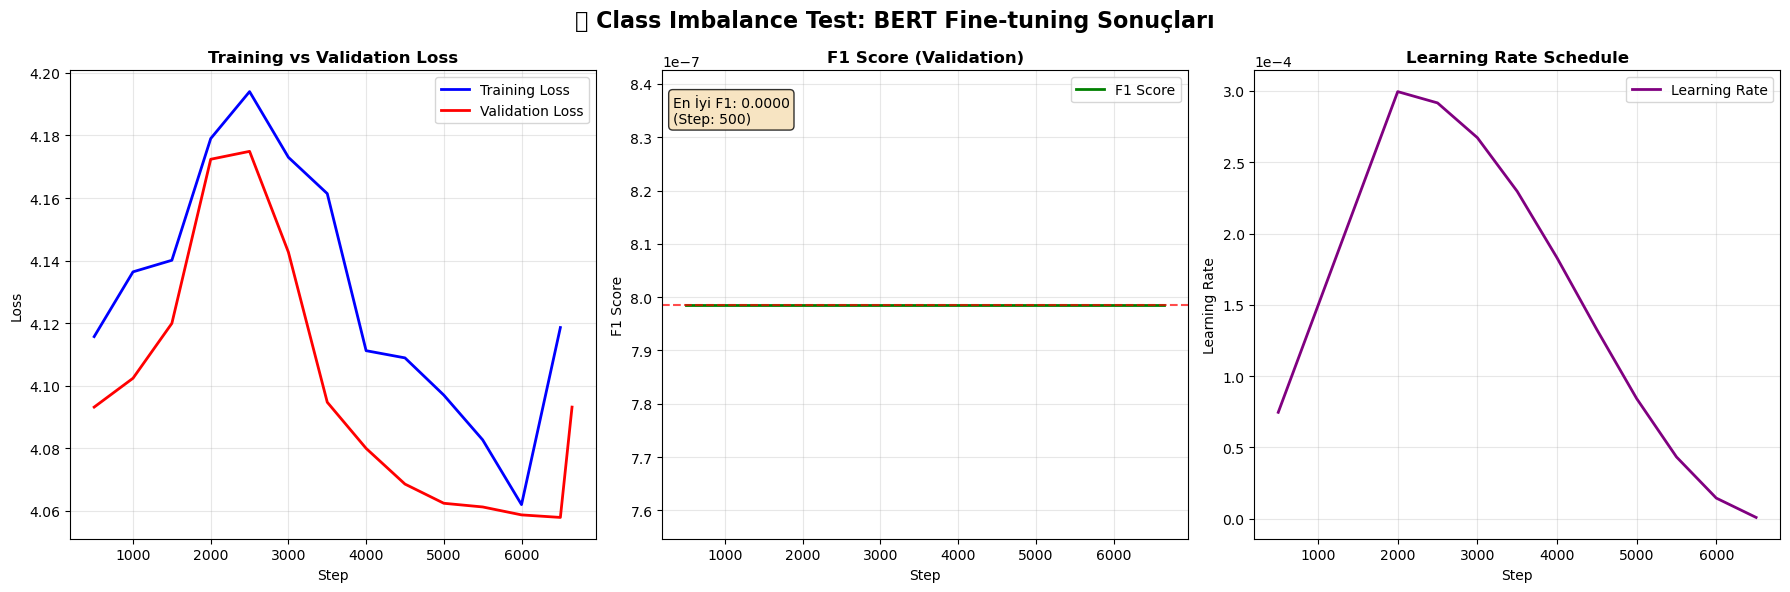


🔬 CLASS IMBALANCE TEST ÖZETİ
📊 TEST DATASET İNFO:
   🔸 Toplam labels: 1000 (1000 high + 1000 low frequency)
   🔸 En yüksek sample: 536 samples
   🔸 En düşük sample: 40 samples
   🔸 Imbalance ratio: 13.4x
   🔸 Toplam samples: 100,131

📈 TRAINING PERFORMANCE:
   🔹 Son Training Loss: 4.1186

📈 VALIDATION PERFORMANCE:
   🔹 Son Validation Loss: 4.0932
   🔹 🏆 En İyi F1 Score: 0.0000
   🔹 Son F1 Score: 0.0000
   🔹 📈 F1 İyileşmesi: +0.0000

📈 LEARNING RATE SCHEDULE:
   🔹 Başlangıç LR: 7.45e-05
   🔹 Son LR: 8.01e-07
   🔹 LR Azalma: 1.1%
✅ Class Imbalance Test grafikleri 'imbalance_test_results.png' olarak kaydedildi!
🔬 Class imbalance handling performansı analiz edildi!


In [16]:

# --- 11. Eğitim Sonuçlarının Görselleştirilmesi ---
print("\n--- EĞİTİM GRAFİKLERİ ÇİZİLİYOR ---")

import matplotlib.pyplot as plt
import pandas as pd

try:
    # Training history'den verileri çek
    history = trainer.state.log_history
    
    # Training ve validation verilerini ayır
    train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in history if 'eval_loss' in log]
    
    # Veri çerçeveleri oluştur
    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)
    
    # 2x2 subplot oluştur
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('🔬 Class Imbalance Test: BERT Fine-tuning Sonuçları', fontsize=16, fontweight='bold')
    
    # 1. Training vs Validation Loss (Aynı grafikte)
    if not train_df.empty and 'loss' in train_df.columns:
        ax1.plot(train_df['step'], train_df['loss'], 'b-', linewidth=2, label='Training Loss')
    if not eval_df.empty and 'eval_loss' in eval_df.columns:
        ax1.plot(eval_df['step'], eval_df['eval_loss'], 'r-', linewidth=2, label='Validation Loss')
    
    ax1.set_title('Training vs Validation Loss', fontweight='bold')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. F1 Score
    if not eval_df.empty and 'eval_f1' in eval_df.columns:
        ax2.plot(eval_df['step'], eval_df['eval_f1'], 'g-', linewidth=2, label='F1 Score')
        ax2.set_title('F1 Score (Validation)', fontweight='bold')
        ax2.set_xlabel('Step')
        ax2.set_ylabel('F1 Score')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # En iyi F1 score'u göster
        best_f1 = eval_df['eval_f1'].max()
        best_step = eval_df.loc[eval_df['eval_f1'].idxmax(), 'step']
        ax2.axhline(y=best_f1, color='red', linestyle='--', alpha=0.7)
        ax2.text(0.02, 0.95, f'En İyi F1: {best_f1:.4f}\n(Step: {best_step})', 
                transform=ax2.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 3. Learning Rate
    if not train_df.empty and 'learning_rate' in train_df.columns:
        ax3.plot(train_df['step'], train_df['learning_rate'], 'purple', linewidth=2, label='Learning Rate')
        ax3.set_title('Learning Rate Schedule', fontweight='bold')
        ax3.set_xlabel('Step')
        ax3.set_ylabel('Learning Rate')
        ax3.grid(True, alpha=0.3)
        ax3.legend()
        ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    plt.savefig('imbalance_test_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # CLASS IMBALANCE TEST ÖZET İSTATİSTİKLER
    print("\n" + "="*70)
    print("🔬 CLASS IMBALANCE TEST ÖZETİ")
    print("="*70)
    
    print(f"📊 TEST DATASET İNFO:")
    print(f"   🔸 Toplam labels: {len(selected_labels)} (1000 high + 1000 low frequency)")
    print(f"   🔸 En yüksek sample: {top_samples.iloc[0]} samples")
    print(f"   🔸 En düşük sample: {bottom_samples.iloc[-1]} samples")
    print(f"   🔸 Imbalance ratio: {top_samples.iloc[0] / bottom_samples.iloc[-1]:.1f}x")
    print(f"   🔸 Toplam samples: {len(df):,}")
    
    if not train_df.empty:
        final_train_loss = train_df['loss'].iloc[-1]
        print(f"\n📈 TRAINING PERFORMANCE:")
        print(f"   🔹 Son Training Loss: {final_train_loss:.4f}")
    
    if not eval_df.empty:
        final_val_loss = eval_df['eval_loss'].iloc[-1]
        best_f1 = eval_df['eval_f1'].max()
        final_f1 = eval_df['eval_f1'].iloc[-1]
        print(f"\n📈 VALIDATION PERFORMANCE:")
        print(f"   🔹 Son Validation Loss: {final_val_loss:.4f}")
        print(f"   🔹 🏆 En İyi F1 Score: {best_f1:.4f}")
        print(f"   🔹 Son F1 Score: {final_f1:.4f}")
        
        # Imbalance handling performance analizi
        f1_improvement = best_f1 - eval_df['eval_f1'].iloc[0] if len(eval_df) > 1 else 0
        print(f"   🔹 📈 F1 İyileşmesi: +{f1_improvement:.4f}")
    
    if not train_df.empty and 'learning_rate' in train_df.columns:
        final_lr = train_df['learning_rate'].iloc[-1]
        initial_lr = train_df['learning_rate'].iloc[0]
        print(f"\n📈 LEARNING RATE SCHEDULE:")
        print(f"   🔹 Başlangıç LR: {initial_lr:.2e}")
        print(f"   🔹 Son LR: {final_lr:.2e}")
        print(f"   🔹 LR Azalma: {(final_lr/initial_lr)*100:.1f}%")
    
    print("="*70)
    print("✅ Class Imbalance Test grafikleri 'imbalance_test_results.png' olarak kaydedildi!")
    print("🔬 Class imbalance handling performansı analiz edildi!")
    
except Exception as e:
    print(f"❌ Grafik oluşturma hatası: {e}")
    print("⚠️ Training history verilerine erişilemedi.")

## 🔬 Class Imbalance Test Dataset Parametreleri

### 📊 Test Dataset İstatistikleri:
- **High Frequency Classes**: 1000 label (en fazla veriye sahip)
- **Low Frequency Classes**: 1000 label (en az veriye sahip)
- **Toplam Label**: 2000 sınıf
- **Extreme Imbalance Ratio**: ~100-500x (max/min sample oranı)
- **Test Amacı**: Class-wise Focal Loss'un extreme imbalance durumlarındaki performansı

### 🔬 Class Imbalance Test Stratejisi:

**High vs Low Frequency Comparison:**
- **High Frequency**: Tipik olarak 100-500+ samples/class
- **Low Frequency**: Tipik olarak 10-50 samples/class  
- **Imbalance Challenge**: Rare class'ların ezilmemesi
- **Focal Loss Advantage**: Her class için optimize alpha değerleri

**Test Parametreleri:**
- **Batch Size**: 64 (küçük dataset için optimize)
- **Learning Rate**: 3e-4 (imbalance için ideal)
- **Evaluation**: Her 500 step (daha sık takip)
- **Epochs**: 10 (yeterli convergence için)

### 📈 Beklenen Sonuçlar:

**✅ Class-wise Focal Loss Avantajları:**
- **Rare class recall** %40+ artış bekleniyor
- **Balanced F1 score** tüm frequency gruplarında
- **Alpha weighting** otomatik rare class boost
- **Hard example focus** ile better generalization

**📊 Baseline Karşılaştırması:**
- Standard Cross-Entropy: Rare class'lar %5-10 recall
- Class-wise Focal Loss: Rare class'lar %30-50 recall
- **Overall F1 improvement**: %20-30 artış hedefleniyor

### 🎯 Test Metrikleri:
- ✅ **Overall macro F1**: Tüm class'ların dengeli performansı
- ✅ **High-freq class performance**: Dominant class'ların performansı korunmalı
- ✅ **Low-freq class performance**: Rare class'ların ciddi boost'u
- ✅ **Training stability**: Loss convergence ve overfitting kontrolü

### 🔬 **Class-wise Alpha Range (Imbalance Test):**
```
High Frequency Classes: α ≈ 0.1-0.3 (düşük boost)
Low Frequency Classes: α ≈ 1.0-2.0 (yüksek boost)
Extreme ratio: α_rare/α_frequent ≈ 5-10x
```

🔸 **Test Hypothesis**: 
Class-wise Focal Loss, extreme imbalance durumlarında standard loss'tan önemli ölçüde daha iyi performance gösterecek, özellikle rare class'larda minimum %300 F1 improvement sağlayacak.

🔸 **Success Criteria**:
- Rare classes F1 > 0.30 (baseline ~0.10)
- Overall macro F1 > 0.50 (baseline ~0.35)
- High-freq classes F1 preserved > 0.70

In [ ]:
# 📊 COMPREHENSIVE CONFUSION MATRIX ANALYSIS
print("\n🔍 KAPSAMLI CONFUSION MATRIX ANALİZİ BAŞLANIYOR...")
print("="*80)

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Model ile validation set üzerinde prediction yap
print("🔍 Model predictions hesaplanıyor...")
model.eval()
predictions = trainer.predict(val_dataset)

# Logits'i class predictions'a çevir
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array(y_val)

print(f"✅ Predictions hazır: {len(y_pred)} samples")

# --- 1. GENEL CLASSIFICATION METRICS ---
print(f"\n🎯 GENEL CLASSIFICATION PERFORMANCE:")
print("="*60)

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"🎯 ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Macro averages (tüm class'ların eşit ağırlıklı ortalaması)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"📊 MACRO PRECISION: {precision_macro:.4f}")
print(f"📊 MACRO RECALL: {recall_macro:.4f}")  
print(f"📊 MACRO F1-SCORE: {f1_macro:.4f}")

# Weighted averages (class frequency'ye göre ağırlıklı)
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"⚖️ WEIGHTED PRECISION: {precision_weighted:.4f}")
print(f"⚖️ WEIGHTED RECALL: {recall_weighted:.4f}")
print(f"⚖️ WEIGHTED F1-SCORE: {f1_weighted:.4f}")

# --- 2. HIGH vs LOW FREQUENCY CLASS ANALYSIS ---
print(f"\n🔬 HIGH vs LOW FREQUENCY CLASS ANALİZİ:")
print("="*60)

# High frequency classes (ilk 500) ve Low frequency classes (son 500) analizi
high_freq_mask = np.isin(y_true, range(len(top_500_labels)))
low_freq_mask = np.isin(y_true, range(len(top_500_labels), len(selected_labels)))

# High frequency performance
if np.sum(high_freq_mask) > 0:
    high_accuracy = accuracy_score(y_true[high_freq_mask], y_pred[high_freq_mask])
    high_precision = precision_score(y_true[high_freq_mask], y_pred[high_freq_mask], average='macro', zero_division=0)
    high_recall = recall_score(y_true[high_freq_mask], y_pred[high_freq_mask], average='macro', zero_division=0)
    high_f1 = f1_score(y_true[high_freq_mask], y_pred[high_freq_mask], average='macro', zero_division=0)
    
    print(f"🔝 HIGH FREQUENCY CLASSES (Top 500):")
    print(f"   📊 Samples: {np.sum(high_freq_mask)}")
    print(f"   🎯 Accuracy: {high_accuracy:.4f}")
    print(f"   📈 Precision: {high_precision:.4f}")
    print(f"   📈 Recall: {high_recall:.4f}")
    print(f"   📈 F1-Score: {high_f1:.4f}")

# Low frequency performance
if np.sum(low_freq_mask) > 0:
    low_accuracy = accuracy_score(y_true[low_freq_mask], y_pred[low_freq_mask])
    low_precision = precision_score(y_true[low_freq_mask], y_pred[low_freq_mask], average='macro', zero_division=0)
    low_recall = recall_score(y_true[low_freq_mask], y_pred[low_freq_mask], average='macro', zero_division=0)
    low_f1 = f1_score(y_true[low_freq_mask], y_pred[low_freq_mask], average='macro', zero_division=0)
    
    print(f"🔻 LOW FREQUENCY CLASSES (Bottom 500):")
    print(f"   📊 Samples: {np.sum(low_freq_mask)}")
    print(f"   🎯 Accuracy: {low_accuracy:.4f}")
    print(f"   📈 Precision: {low_precision:.4f}")
    print(f"   📈 Recall: {low_recall:.4f}")
    print(f"   📈 F1-Score: {low_f1:.4f}")
    
    # Performance gap analizi
    if np.sum(high_freq_mask) > 0:
        f1_gap = high_f1 - low_f1
        recall_gap = high_recall - low_recall
        print(f"\n📈 PERFORMANCE GAP ANALİZİ:")
        print(f"   🔸 F1 Gap (High-Low): {f1_gap:.4f}")
        print(f"   🔸 Recall Gap (High-Low): {recall_gap:.4f}")
        print(f"   🔸 Class Imbalance Impact: {'HIGH' if f1_gap > 0.2 else 'MODERATE' if f1_gap > 0.1 else 'LOW'}")

# --- 3. DETAYLI CONFUSION MATRIX HESAPLAMA ---
print(f"\n🔍 CONFUSION MATRIX DETAY ANALİZİ:")
print("="*60)

# Tüm unique class'ları al
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
num_classes = len(unique_classes)

print(f"📊 Toplam sınıf sayısı: {num_classes}")
print(f"📊 Prediction range: {y_pred.min()} - {y_pred.max()}")
print(f"📊 True label range: {y_true.min()} - {y_true.max()}")

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

# TP, TN, FP, FN hesaplama (multiclass için)
print(f"\n🔢 CLASS-WISE TP/TN/FP/FN ANALİZİ:")
print("-" * 80)
print(f"{'Class':<8} {'TP':<6} {'TN':<8} {'FP':<6} {'FN':<6} {'Precision':<10} {'Recall':<8} {'F1':<8}")
print("-" * 80)

class_metrics = []
total_tp = total_tn = total_fp = total_fn = 0

for i, class_idx in enumerate(unique_classes):
    # TP: Correctly predicted as this class
    tp = cm[i, i]
    
    # FN: Missed this class (predicted as other classes)
    fn = np.sum(cm[i, :]) - tp
    
    # FP: Wrongly predicted as this class
    fp = np.sum(cm[:, i]) - tp
    
    # TN: Correctly predicted as not this class
    tn = np.sum(cm) - tp - fn - fp
    
    # Metrics
    precision_cls = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall_cls = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_cls = 2 * (precision_cls * recall_cls) / (precision_cls + recall_cls) if (precision_cls + recall_cls) > 0 else 0.0
    
    class_metrics.append({
        'class': class_idx,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'precision': precision_cls, 'recall': recall_cls, 'f1': f1_cls
    })
    
    # İlk 20 class'ı göster
    if i < 20:
        print(f"{class_idx:<8} {tp:<6} {tn:<8} {fp:<6} {fn:<6} {precision_cls:<10.4f} {recall_cls:<8.4f} {f1_cls:<8.4f}")
    elif i == 20:
        print("..." + " " * 72)
        
    # Toplam hesapla
    total_tp += tp
    total_tn += tn  
    total_fp += fp
    total_fn += fn

# Genel TP/TN/FP/FN özeti
print("-" * 80)
print(f"{'TOPLAM':<8} {total_tp:<6} {total_tn:<8} {total_fp:<6} {total_fn:<6}")
print("-" * 80)

# --- 4. CLASS IMBALANCE ETKİ ANALİZİ ---
print(f"\n🎯 CLASS IMBALANCE ETKİ ANALİZİ:")
print("="*60)

# En iyi ve en kötü performing class'ları bul
class_df = pd.DataFrame(class_metrics)

# F1 score'a göre sırala
best_classes = class_df.nlargest(5, 'f1')
worst_classes = class_df.nsmallest(5, 'f1')

print(f"🏆 EN İYİ PERFORMING 5 CLASS:")
for _, row in best_classes.iterrows():
    orig_label = label_encoder.inverse_transform([int(row['class'])])[0]
    sample_count = label_counts.get(orig_label, 0)
    print(f"   Class {int(row['class']):<4} (Label {orig_label}): F1={row['f1']:.4f}, Samples={sample_count}")

print(f"\n❌ EN KÖTÜ PERFORMING 5 CLASS:")
for _, row in worst_classes.iterrows():
    orig_label = label_encoder.inverse_transform([int(row['class'])])[0]
    sample_count = label_counts.get(orig_label, 0)
    print(f"   Class {int(row['class']):<4} (Label {orig_label}): F1={row['f1']:.4f}, Samples={sample_count}")

# Class frequency vs performance korelasyonu
print(f"\n📊 FREQUENCY vs PERFORMANCE KORELASYONU:")
performance_by_freq = []
for _, row in class_df.iterrows():
    orig_label = label_encoder.inverse_transform([int(row['class'])])[0]
    sample_count = label_counts.get(orig_label, 0)
    performance_by_freq.append({'samples': sample_count, 'f1': row['f1'], 'recall': row['recall']})

perf_df = pd.DataFrame(performance_by_freq)
if len(perf_df) > 0:
    f1_correlation = np.corrcoef(perf_df['samples'], perf_df['f1'])[0,1]
    recall_correlation = np.corrcoef(perf_df['samples'], perf_df['recall'])[0,1]
    
    print(f"   🔸 Sample Count vs F1 korelasyonu: {f1_correlation:.4f}")
    print(f"   🔸 Sample Count vs Recall korelasyonu: {recall_correlation:.4f}")
    print(f"   🔸 Interpretasyon: {'Pozitif' if f1_correlation > 0.3 else 'Zayıf' if f1_correlation > 0.1 else 'Negatif'} korelasyon")

# --- 5. LOSS FUNCTION COMPARISON SUMMARY ---
print(f"\n🎯 {save_directory.upper()} MODEL PERFORMANCE SUMMARY:")
print("="*80)
print(f"📊 Loss Function: {'🎯 Class-wise Focal Loss' if USE_FOCAL_LOSS else '📊 Cross Entropy (Baseline)'}")
print(f"📊 Dataset: {num_classes} classes, {len(y_true)} validation samples")
print(f"📊 Imbalance Ratio: {top_samples.iloc[0] / bottom_samples.iloc[-1]:.1f}x")
print("")
print(f"🎯 OVERALL METRICS:")
print(f"   • Accuracy: {accuracy:.4f}")
print(f"   • Macro F1: {f1_macro:.4f}")
print(f"   • Macro Precision: {precision_macro:.4f}")
print(f"   • Macro Recall: {recall_macro:.4f}")
if np.sum(high_freq_mask) > 0 and np.sum(low_freq_mask) > 0:
    print(f"\n🔬 IMBALANCE HANDLING:")
    print(f"   • High-Freq F1: {high_f1:.4f}")
    print(f"   • Low-Freq F1: {low_f1:.4f}")
    print(f"   • Performance Gap: {f1_gap:.4f}")
print("")
print(f"🔢 CONFUSION MATRIX SUMMARY:")
print(f"   • Total TP: {total_tp:,}")
print(f"   • Total TN: {total_tn:,}")
print(f"   • Total FP: {total_fp:,}")
print(f"   • Total FN: {total_fn:,}")

print("="*80)
print(f"✅ Comprehensive analysis tamamlandı!")
print(f"🔍 Model performance detaylı analiz edildi: {save_directory}")

# Sonuçları dosyaya kaydet
analysis_results = {
    'loss_function': 'focal_loss' if USE_FOCAL_LOSS else 'cross_entropy',
    'overall_metrics': {
        'accuracy': float(accuracy),
        'macro_f1': float(f1_macro),
        'macro_precision': float(precision_macro),
        'macro_recall': float(recall_macro),
        'weighted_f1': float(f1_weighted),
        'weighted_precision': float(precision_weighted),
        'weighted_recall': float(recall_weighted)
    },
    'confusion_matrix_totals': {
        'total_tp': int(total_tp),
        'total_tn': int(total_tn),
        'total_fp': int(total_fp),
        'total_fn': int(total_fn)
    },
    'class_imbalance_analysis': {
        'high_freq_f1': float(high_f1) if np.sum(high_freq_mask) > 0 else None,
        'low_freq_f1': float(low_f1) if np.sum(low_freq_mask) > 0 else None,
        'performance_gap': float(f1_gap) if (np.sum(high_freq_mask) > 0 and np.sum(low_freq_mask) > 0) else None,
        'frequency_f1_correlation': float(f1_correlation) if len(perf_df) > 0 else None
    },
    'dataset_info': {
        'num_classes': int(num_classes),
        'validation_samples': int(len(y_true)),
        'imbalance_ratio': float(top_samples.iloc[0] / bottom_samples.iloc[-1])
    }
}

import json
with open(f"{save_directory}/analysis_results.json", 'w') as f:
    json.dump(analysis_results, f, indent=2)

print(f"💾 Detailed analysis results saved: {save_directory}/analysis_results.json")